In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

print('Tensorflow version: {}'.format(tf.__version__))

2024-06-03 01:17:58.234727: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 01:17:58.234938: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-03 01:17:58.236809: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-03 01:17:58.260618: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 01:17:58.733188: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

Tensorflow version: 2.16.1


### Data preprocessing - Version 1
data content : 1 stock only

In [8]:
# Version 1
# 讀取數據
file_path = 'tsmc_prices_complete_datetime_2010-2023.csv'  # 確保你的數據集準備好
df = pd.read_csv(file_path)
data = df[['open', 'high', 'low', 'close']].values  # 包含多個特徵

# 標準化數據
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 創建數據集
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, -1])  # 使用'close'作為目標變量
    return np.array(dataX), np.array(dataY)

# 參數
time_step = 30
train_size = int(len(data_scaled) * 0.8)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[0:train_size, :]
val_data = data_scaled[train_size:train_size+val_size, :]
test_data = data_scaled[train_size+val_size:, :]

x_train, y_train = create_dataset(train_data, time_step)
x_val, y_val = create_dataset(val_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# 調整輸入形狀以符合模型需求
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])

print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_val.shape:', x_val.shape)
print('y_val.shape:', y_val.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)


x_train.shape: (2712, 30, 4)
y_train.shape: (2712,)
x_val.shape: (311, 30, 4)
y_val.shape: (311,)
x_test.shape: (313, 30, 4)
y_test.shape: (313,)


### Data preprocessing - Version 2
data content : multiple stocks

In [17]:
# Version 2

# 讀取合併後的數據
file_path = './Datasets/1303_stock_prices.csv'
df = pd.read_csv(file_path)

# 創建數據集並按8:1:1的比例切分
def create_and_split_dataset(df, time_step=30):
    trainX, trainY, valX, valY, testX, testY = [], [], [], [], [], []
    scalers = {}
    for stock in df['ticker'].unique():
        stock_data = df[df['ticker'] == stock].copy()
        data = stock_data[['close']].values  # 'volume', 'open', 'high', 'low', 
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_scaled = scaler.fit_transform(data)
        scalers[stock] = scaler  # 保存每支股票的標準化器
        
        x, y = [], []
        for i in range(len(data_scaled) - time_step - 1):
            a = data_scaled[i:(i + time_step), :]
            x.append(a)
            y.append(data_scaled[i + time_step, -1])  # 第time_step+1天的'close'價格作為目標
        
        x, y = np.array(x), np.array(y)
        
        train_size = int(len(x) * 0.8)
        val_size = int(len(x) * 0.1)
        
        trainX.extend(x[:train_size])
        trainY.extend(y[:train_size])
        valX.extend(x[train_size:train_size + val_size])
        valY.extend(y[train_size:train_size + val_size])
        testX.extend(x[train_size + val_size:])
        testY.extend(y[train_size + val_size:])
    
    return (np.array(trainX), np.array(trainY),
            np.array(valX), np.array(valY),
            np.array(testX), np.array(testY),
            scalers)

# 創建標準化器
scaler = MinMaxScaler(feature_range=(0, 1))

# 創建數據集函數
def create_dataset(stock_data, time_step=30):
    dataX, dataY = [], []
    data = stock_data[['close']].values  # 'volume', 'open', 'high', 'low', 
    data_scaled = scaler.fit_transform(data)
    for i in range(len(data_scaled) - time_step - 1):
        a = data_scaled[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(data_scaled[i + time_step, -1])  # 使用'close'作為目標變量
    return np.array(dataX), np.array(dataY)

# 參數
time_step = 30

# 創建並切分數據集
x_train, y_train, x_val, y_val, x_test, y_test, scalers = create_and_split_dataset(df, time_step)

# 調整輸入形狀以符合模型需求
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])

print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"x_val.shape: {x_val.shape}")
print(f"y_val.shape: {y_val.shape}")
print(f"x_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test.shape}")


x_train.shape: (2796, 30, 1)
y_train.shape: (2796,)
x_val.shape: (349, 30, 1)
y_val.shape: (349,)
x_test.shape: (350, 30, 1)
y_test.shape: (350,)


### Transformer Block

In [18]:
# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

### Model Definition

In [19]:
# Model Definition
inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ input_layer_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 30, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 30, 1)     │          0 │ dropout_9[0][0],  │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 30, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 30, 4)     │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 30, 1)     │          5 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 30, 1)     │          0 │ dense_9[0][0],    │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1)         │          0 │ add_5[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 1)         │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 20)        │         40 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         21 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,247 (28.31 KB)

 Trainable params: 7,247 (28.31 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [20]:
# Train the model
# model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=64, verbose=1)

from keras.callbacks import EarlyStopping


history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=200,
                    validation_data=(x_val, y_val),
                    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)])


Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1233 - val_loss: 0.1018
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0389 - val_loss: 0.0768
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0345 - val_loss: 0.0699
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0309 - val_loss: 0.0621
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0262 - val_loss: 0.0538
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0202 - val_loss: 0.0415
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0185 - val_loss: 0.0343
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0137 - val_loss: 0.0255
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0101 - val_loss: 0.0155
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0092 - val_loss: 0.0163
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - val_loss: 0.0142
Epoch 12/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 

### Save model as a weight file

In [21]:
# Store the model as a .h5 file
# model.save('10_stocks_pretrained_model.h5')
model.save('./Weights/TransformerModel/1303_model.keras')


### Model Performance
compute RMSE of model

In [22]:
def inverse_transform(scalers, data, tickers, original_shape):
    result = []
    for i in range(len(data)):
        ticker = tickers[i]
        scaler = scalers[ticker]
        # 構建與原始數據形狀一致的數據，用零填充其他列
        scaled_data = np.concatenate([np.zeros((1, original_shape - 1)), data[i].reshape(1, -1)], axis=1)
        result.append(scaler.inverse_transform(scaled_data)[0, -1])  # 取出反標準化後的close值
    return np.array(result)

# 生成對應的tickers列表，確保每個列表的長度與對應數據集長度一致
train_tickers = []
val_tickers = []
test_tickers = []

for stock in df['ticker'].unique():
    stock_data = df[df['ticker'] == stock]
    x, y = create_dataset(stock_data, time_step)
    train_size = int(len(x) * 0.8)
    val_size = int(len(x) * 0.1)
    test_size = len(x) - train_size - val_size

    train_tickers.extend([stock] * train_size)
    val_tickers.extend([stock] * val_size)
    test_tickers.extend([stock] * test_size)

train_tickers = np.array(train_tickers)
val_tickers = np.array(val_tickers)
test_tickers = np.array(test_tickers)

# Make predictions
train_predict = model.predict(x_train)
val_predict = model.predict(x_val)
test_predict = model.predict(x_test)

# Inverse transform predictions and true values
original_shape = x_train.shape[2]  # 獲取原始數據的特徵數量
train_predict = inverse_transform(scalers, train_predict, train_tickers, original_shape)
val_predict = inverse_transform(scalers, val_predict, val_tickers, original_shape)
test_predict = inverse_transform(scalers, test_predict, test_tickers, original_shape)

y_train_true = inverse_transform(scalers, y_train.reshape(-1, 1), train_tickers, original_shape)
y_val_true = inverse_transform(scalers, y_val.reshape(-1, 1), val_tickers, original_shape)
y_test_true = inverse_transform(scalers, y_test.reshape(-1, 1), test_tickers, original_shape)

# Evaluate the model (Calculate RMSE or other metrics)
train_rmse = math.sqrt(mean_squared_error(y_train_true, train_predict))
val_rmse = math.sqrt(mean_squared_error(y_val_true, val_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_true, test_predict))

print(f"Train RMSE: {train_rmse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Test RMSE: {test_rmse}")


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train RMSE: 3.3263016920556936
Validation RMSE: 4.288048870578374
Test RMSE: 3.077107836228694


### Model Performance
predict on testing set and illustrate a chart

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


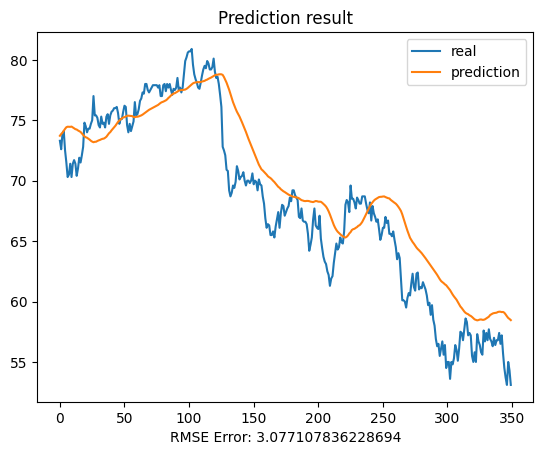

In [23]:
# Make predictions
test_predict = model.predict(x_test)

original_shape = x_train.shape[2]  # 獲取原始數據的特徵數量

# Inverse transform true values and predictions
test_predict = inverse_transform(scalers, test_predict, test_tickers, original_shape)
y_test_true = inverse_transform(scalers, y_test.reshape(-1, 1), test_tickers, original_shape)

# Plot the results
plt.figure(1)
plt.plot(y_test_true, label='real')
plt.plot(test_predict, label='prediction')

# Calculate and display RMSE
rmse = np.sqrt(mean_squared_error(y_test_true, test_predict))
plt.xlabel('RMSE Error: {}'.format(rmse))
plt.legend()
plt.title('Prediction result')
plt.show()

### Model Performance
currently no use

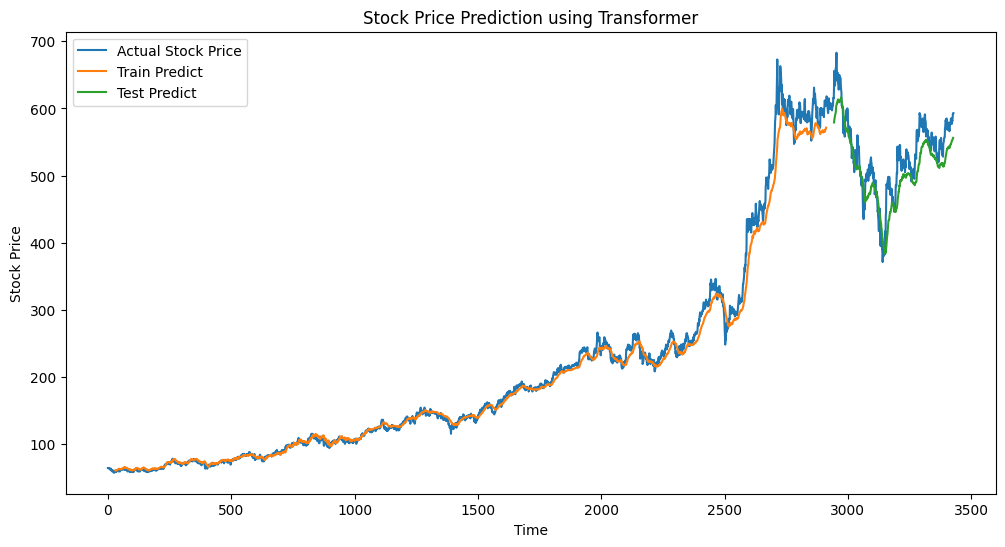

In [8]:
# Plotting the results
# Adjust the time_step offset for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(data_scaled)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('Stock Price Prediction using Transformer')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [15]:
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
# print('real: ', y_real.shape)


plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
# plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
rmse = np.sqrt(mean_squared_error(y_real, y_predict))
plt.xlabel('RMSE Error: {}'.format(rmse))
plt.legend()
plt.title('Prediction result')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)